# <font color="maroon">Chapter 3: A Basic NMR Analysis</font>

<a href="https://githubtocolab.com/alsinmr/pyDR_tutorial/blob/main/ColabNotebooks/Ch3_basic_NMR.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

In this example, we load an NMR data set and demonstrate how to go about fitting it. For this, we need a text file with the measured relaxation rates and experimental data in it (e.g. [HETs_15N.txt](https://github.com/alsinmr/pyDR_tutorial/raw/main/data/HETs_15N.txt)). This is provided for this example, but one can also use one's own data. Make sure to follow the prescribed file format. Entries are separated by tabs within a given line and by carriage returns over multiple lines. An example data file is printed out as an example.

In [1]:
# SETUP pyDR
import os
os.chdir('../..')

In [2]:
#Imports
import pyDR

## Loading NMR data

First, we load a data object and discuss some of its contents, including plotting the experimental data. The contents of the data text file are shown below (entries are truncated for convenient viewing).

In [3]:
# Load the data
data=pyDR.IO.readNMR('pyDR/examples/HETs15N/HETs_15N.txt')

First, we discuss the data object briefly to understand the contents of the data object. There are a few key components:
* Relaxation rate constants: **data.R**
* Standard deviation of the relaxation rate constants: **data.Rstd**
* Order parameters, given as $S^2$ (these are optional): **data.S2**
* Standard deviation of $S^2$: **data.S2std**
* Labels for the data: **data.label**
* Sensitivity of the data: **data.sens**
* Detector object for processing the data: **data.detect**
* Experimental parameters: **data.info**
    * This is a reference to data.sens.info
* Details on the data / processing so far: **data.details**
* Selection object, which connects data to a pdb of the molecular structure: **data.select**
    * Not required: we'll connect the data to a pdb later

A number of other functions and data objects are also attached to data, but these are for data processing, or analysis of the processing after an initial fit.

Below, you can investigate these different components. We show data.info, which provides the various relevant experimental parameters for determining the sensitivities of the 8 experiments. Note that this data set also includes $S^2$, which is treated separately and does not show up in data.info.

In [4]:
data.info

                   0           1           2           3           4           5           6           7
Type              R1          R1          R1         R1p         R1p         R1p         R1p         R1p
v0               400         500         850         850         850         850         500         500
v1               0.0         0.0         0.0        10.8        16.1        24.5        37.6        50.8
vr                 0           0           0          60          60          60          60          60
offset             0           0           0           0           0           0           0           0
stdev     0.00249149  0.00554449  0.00208680  1.08759999  0.65464997  0.68395000  0.56901997  1.18330001
med_val   0.04465600  0.03731900  0.02731099  3.81399989  3.52609992  3.61940002  3.92989993  5.97370004
Nuc              15N         15N         15N         15N         15N         15N         15N         15N
Nuc1              1H          1H          1H          1

These are the parameters found by default in data.info. Not all parameters are required for all experiments. If unspecified, these go to some default value (usually 0 or None).
* v0: External magnetic field, given as the $^1$H frequency in MHz
* v1: Spin-locking strength for $R_{1\rho}$ experiments (applied to the relaxing nucleus), given in kHz
* vr: Magic angle spinning frequency, given in kHz
* offset: Offset applied to the spin-lock, given in kHz
* stdev: Median standard deviation for data set
* med_val: Median relaxation rate constant for data set
* Nuc: Nucleus being relaxed (atomic number, symbol)
* Nuc1: Nucleus (or list of nuclei) relaxing Nuc via dipole coupling
* dXY: Dipole coupling (or list of couplings), given in Hz Same length as Nuc1
    * Given as the full anisotropy of the dipole coupling, which is twice the coupling constant
* CSA: Chemical shift anisotropy of nucleus being relaxed (z-component in ppm)
* eta: Asymmetry of the CSA, which is unitless
* CSoff: Unimplemented
* QC: Quadrupole coupling in Hz
* etaQ: Asymmetry of the quadrupole coupling
* theta: Angle between the CSA and dipole tensors (for cross-correlated cross-relaxation)

A graphical summary of the data object is obtained via data.plot (can use various plotting options, such as plot type, etc.). The plt_obj provides a variety of functions for manipulating the plot.

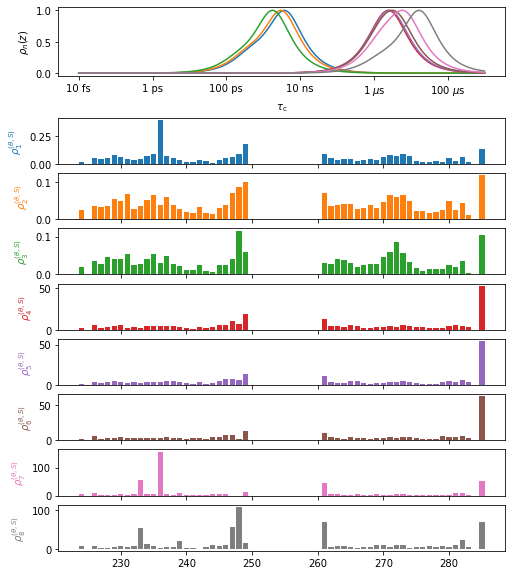

In [5]:
plt_obj=data.plot(style='bar')
plt_obj.fig.set_size_inches([8,10])

## Processing NMR experimental data

Now, we want to process this data set. To do so, we first must optimize a set of detectors to analyze it with. The detector object is already attached to the data object, found in data.detect. So, we just need to run the optimization algorithm. We also will include $S^2$ in the data analysis, which we must also specify. We will use 4 detectors plus one more for $S^2$ data, to yield 5 total. Once the detector analysis is run, we may simply run the "fit" function to obtain the detector analysis, and finally plot the results.

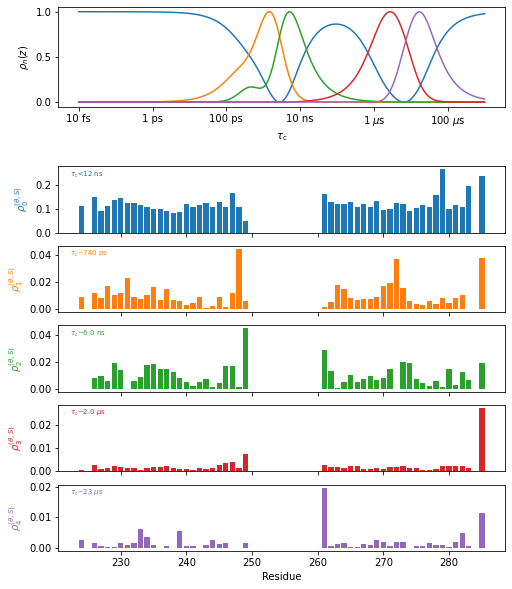

In [6]:
data.detect.r_auto(4).inclS2()  #Optimize the detectors
fit=data.fit()  #Fit the data

plt_obj=fit.plot(style='bar')
plt_obj.fig.set_size_inches([8,10])
plt_obj.show_tc()
_=plt_obj.ax[-1].set_xlabel('Residue')

Finally, we can check the fit quality by comparing the back-calculated relaxation rate constants to the original experimental relaxation rate constants. The original data is shown as bar plots with error bars and the fitted rate constants are scatter points (filled circles).

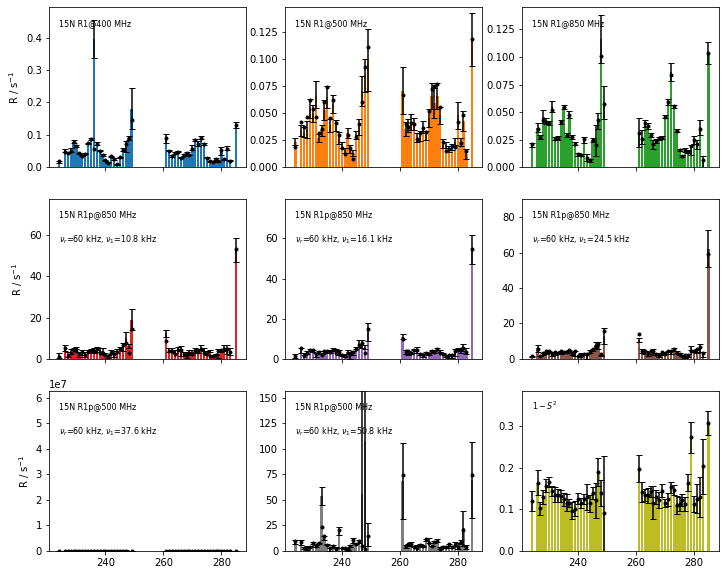

In [7]:
fig=fit.plot_fit()[0].axes.figure
fig.set_size_inches([12,10])

## Connecting data to locations in a structure, 3D visualization

It is often useful to see how relaxation parameters relate to the structure. Also, for sake of comparison of dynamics between methods, one may assign a common set of labels, but alternatively, one may associate dynamics via the structure. We attach a structure to the data via the selection objection. The selection is a list of atom groups (from the [MDAnalysis](http://mdanalysis.org/) Python module), with the same number of entries as the number of data points in the data object (len(data)).

We will also include a 'Project' here. Projects add a lot of convient functionality; here they provide us with convenient communcation with [ChimeraX](https://www.cgl.ucsf.edu/chimerax/).

In [8]:
proj=pyDR.Project()  #Project without storage location
proj.append_data(data) #Add data to project
data.select=pyDR.MolSelect(topo='2kj3') #Add selection to data
#Note: you can use a local file, or download from the pdb database with 4-letter code

# data.label contains the residue numbers, so we can just point to these. 
#The pdb contains 3 copies of HET-s (segments A,B,C), so we have to select just one segment
_=data.select.select_bond(Nuc='N',resids=data.label,segids='B') #Define the selection

fit=data.fit()  #Selections are automatically passed from data to fit
#but, we do need to re-run the fit to achieve this

Detector analysis can be viewed directly on the molecule, with detector responses represented as color intensity and atom radius. This works externally from Jupyter notebooks via ChimeraX (must be separately installed, and the path provided to pyDR, see below), or within the Jupyter notebook, via NGLviewer (must be installed in Python with pip or conda).

### Visualization via [ChimeraX](https://www.cgl.ucsf.edu/chimerax/)

In [9]:
#Set chimera path (only required once)
pyDR.chimeraX.chimeraX_funs.set_chimera_path('/Applications/ChimeraX-1.5.app/Contents/MacOS/ChimeraX')

fit.chimera()
proj.chimera.command_line('~show ~/B@N,C,CA') #Send command to chimera

You can mouse over the different detector names in ChimeraX ($\rho_0$,$\rho_1$,etc.), to view the different detector responses. However, the size of the responses are on different scales, so only $\rho_0$ is visible on the default scale (often a problem with rigid proteins). Run the cells below to view the different responses by excluding some of the detectors via *rho_index*.

In [10]:
proj.chimera.close()
fit.chimera(rho_index=[1,2])
proj.chimera.command_line('~show ~/B@N,C,CA')

In [11]:
proj.chimera.close()
fit.chimera(rho_index=[3,4],scaling=200)
proj.chimera.command_line('~show ~/B@N,C,CA')

### Visualization with [NGL Viewer](https://nglviewer.org/)
```
fit.nglview(det_num)  #Runs NGLviewer for Jupyter notebooks (coloring may fail in Google Colab)
```